# Demo code for glow

Glow is a normalizing flow, which can be used to create realisitic looking faces. Here we use a pretrained network.  

**Goal:** In this notebook you will do your first classification. You will see that fully connected networks without a hidden layer can only learn linar decision boundaries, while fully connected networks with hidden layers are able to learn non-linear decision boundaries.

**Usage:** The idea of the notebook is that you try to understand the provided code. Run it, check the output, and play with it by slightly changing the code.

**Dataset:** The dataset is the celeba-Hq dataset with of pictures from celebrities.


The code has be taken in great part from: https://github.com/openai/glow/

It's highly recomended to use the colab version. Since the weights are storred in TensorFlow 1, we use a TF 1 version.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('1.14')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==1.14.0
    print('Please install tensorflow 1.14 to run this notebook')
    
print('Tensorflow version: ',tf.__version__)

Tensorflow version:  1.14.0


### Downloading of the weights

In [2]:
# If blocksparse doesn't install, use unoptimized model (and set optimized=False in model.py)
!curl https://storage.googleapis.com/glow-demo/large3/graph_unoptimized.pb > graph_unoptimized.pb
# Get manipulation vectors
!curl https://storage.googleapis.com/glow-demo/z_manipulate.npy > z_manipulate.npy
tf.gfile.MkDir('test')
!curl https://raw.githubusercontent.com/openai/glow/master/demo/test/img.png  > test/img.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  854M  100  854M    0     0  91.8M      0  0:00:09  0:00:09 --:--:--  114M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.0M  100 30.0M    0     0  61.7M      0 --:--:-- --:--:-- --:--:-- 61.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96427  100 96427    0     0   418k      0 --:--:-- --:--:-- --:--:--  420k


## Loading of the model

Here, we use the code provided by openAI.

In [2]:
#@title Functions provided by openAI { run: "auto" }
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
from PIL import Image
from threading import Lock


lock = Lock()


def get(name):
    return tf.get_default_graph().get_tensor_by_name('import/' + name + ':0')


def tensorflow_session():
    # Init session and params
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # Pin GPU to local rank (one GPU per process)
    config.gpu_options.visible_device_list = str(0)
    sess = tf.Session(config=config)
    return sess


optimized = False
if optimized:
    # Optimized model. Twice as fast as
    # 1. we freeze conditional network (label is always 0)
    # 2. we use fused kernels
    import blocksparse
    graph_path = 'graph_optimized.pb'
    inputs = {
        'dec_eps_0': 'dec_eps_0',
        'dec_eps_1': 'dec_eps_1',
        'dec_eps_2': 'dec_eps_2',
        'dec_eps_3': 'dec_eps_3',
        'dec_eps_4': 'dec_eps_4',
        'dec_eps_5': 'dec_eps_5',
        'enc_x': 'input/enc_x',
    }
    outputs = {
        'dec_x': 'model_3/Cast_1',
        'enc_eps_0': 'model_2/pool0/truediv_1',
        'enc_eps_1': 'model_2/pool1/truediv_1',
        'enc_eps_2': 'model_2/pool2/truediv_1',
        'enc_eps_3': 'model_2/pool3/truediv_1',
        'enc_eps_4': 'model_2/pool4/truediv_1',
        'enc_eps_5': 'model_2/truediv_4'
    }

    def update_feed(feed_dict, bs):
        return feed_dict
else:
    graph_path = 'graph_unoptimized.pb'
    inputs = {
        'dec_eps_0': 'Placeholder',
        'dec_eps_1': 'Placeholder_1',
        'dec_eps_2': 'Placeholder_2',
        'dec_eps_3': 'Placeholder_3',
        'dec_eps_4': 'Placeholder_4',
        'dec_eps_5': 'Placeholder_5',
        'enc_x': 'input/image',
        'enc_x_d': 'input/downsampled_image',
        'enc_y': 'input/label'
    }
    outputs = {
        'dec_x': 'model_1/Cast_1',
        'enc_eps_0': 'model/pool0/truediv_1',
        'enc_eps_1': 'model/pool1/truediv_1',
        'enc_eps_2': 'model/pool2/truediv_1',
        'enc_eps_3': 'model/pool3/truediv_1',
        'enc_eps_4': 'model/pool4/truediv_1',
        'enc_eps_5': 'model/truediv_4'
    }

    def update_feed(feed_dict, bs):
        x_d = 128 * np.ones([bs, 128, 128, 3], dtype=np.uint8)
        y = np.zeros([bs], dtype=np.int32)
        feed_dict[enc_x_d] = x_d
        feed_dict[enc_y] = y
        return feed_dict

with tf.gfile.GFile(graph_path, 'rb') as f:
    graph_def_optimized = tf.GraphDef()
    graph_def_optimized.ParseFromString(f.read())

sess = tensorflow_session()
tf.import_graph_def(graph_def_optimized)

print("Loaded model")
n_eps = 6

# Encoder
enc_x = get(inputs['enc_x'])
enc_eps = [get(outputs['enc_eps_' + str(i)]) for i in range(n_eps)]
if not optimized:
    enc_x_d = get(inputs['enc_x_d'])
    enc_y = get(inputs['enc_y'])

# Decoder
dec_x = get(outputs['dec_x'])
dec_eps = [get(inputs['dec_eps_' + str(i)]) for i in range(n_eps)]

eps_shapes = [(128, 128, 6), (64, 64, 12), (32, 32, 24),
              (16, 16, 48), (8, 8, 96), (4, 4, 384)]
eps_sizes = [np.prod(e) for e in eps_shapes]

eps_size = 256 * 256 * 3 #assert(np.sum(eps_sizes) == eps_size)


def run(sess, fetches, feed_dict):
    with lock:
        # Locked tensorflow so average server response time to user is lower
        result = sess.run(fetches, feed_dict)
    return result


def flatten_eps(eps):
    # [BS, eps_size]
    return np.concatenate([np.reshape(e, (e.shape[0], -1)) for e in eps], axis=-1)


def unflatten_eps(feps):
    index = 0
    eps = []
    bs = feps.shape[0]  # feps.size // eps_size
    for shape in eps_shapes:
        eps.append(np.reshape(
            feps[:, index: index+np.prod(shape)], (bs, *shape)))
        index += np.prod(shape)
    return eps


def encode(img):
    if len(img.shape) == 3:
        img = np.expand_dims(img, 0)
    bs = img.shape[0]
    assert img.shape[1:] == (256, 256, 3)
    feed_dict = {enc_x: img}

    update_feed(feed_dict, bs)  # For unoptimized model
    return flatten_eps(run(sess, enc_eps, feed_dict))


def decode(feps):
    if len(feps.shape) == 1:
        feps = np.expand_dims(feps, 0)
    bs = feps.shape[0]
    # assert len(eps) == n_eps
    # for i in range(n_eps):
    #     shape = (BATCH_SIZE, 128 // (2 ** i), 128 // (2 ** i), 6 * (2 ** i) * (2 ** (i == (n_eps - 1))))
    #     assert eps[i].shape == shape
    eps = unflatten_eps(feps)

    feed_dict = {}
    for i in range(n_eps):
        feed_dict[dec_eps[i]] = eps[i]

    update_feed(feed_dict, bs)  # For unoptimized model
    return run(sess, dec_x, feed_dict)
 


Loaded model


In [3]:
for i,e in enumerate(eps_shapes):
  print('z_{}'.format(i+1),e)

z_1 (128, 128, 6)
z_2 (64, 64, 12)
z_3 (32, 32, 24)
z_4 (16, 16, 48)
z_5 (8, 8, 96)
z_6 (4, 4, 384)


# Fun with deep learning

## Random samples

We create a random sample from $256 \cdot 256 \cdot 3$ independent Gaussians. We do not sample from $N(0,1)$ but from $N(0,0.7)$, which has been empirically found to create nicer samples. 

This is going from Z $\rightarrow$ Image. Here we use a random Z $\sim N(0,1)$ 

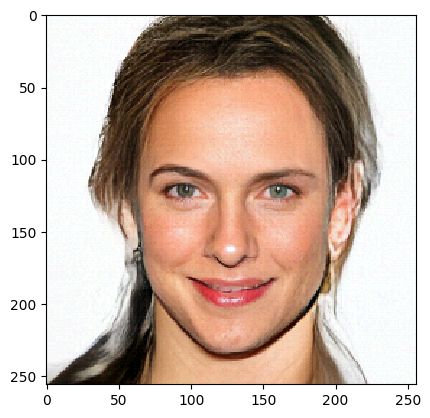

In [4]:
def random(bs=1, eps_std=0.7):
    feps = np.random.normal(scale=eps_std, size=[bs, eps_size]) #eps_size = 256*256*3
    return decode(feps), feps

img = random()[0][0]
plt.imshow(img)

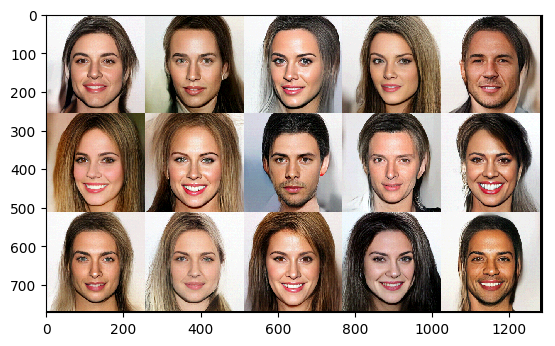

In [8]:
# Creation of figure with 15 random samples
can = np.zeros((3*257,5*257,3),dtype='uint8')
for i in range(3):
  for j in range(5):
    img = random()[0][0]
    s = i*256
    sx = j*256
    can[s:(s+256) , sx:(sx+256),0:3] = img

plt.imshow(can)

# from google.colab import drive
# drive.mount('/content/drive')
# plt.imsave('/content/drive/My Drive/some_random_imges.png',can)

## Going from images to latent vectors 

Now we have a look at the reversed transformation, where we go from images to the latent space. 

Image $\rightarrow$ Z



In [9]:
!curl https://raw.githubusercontent.com/openai/glow/master/demo/web/media/beyonce.png > test/beyonce.jpg
!curl https://raw.githubusercontent.com/openai/glow/master/demo/web/media/leo.png > test/leo.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  123k  100  123k    0     0   695k      0 --:--:-- --:--:-- --:--:--  691k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   97k  100   97k    0     0   586k      0 --:--:-- --:--:-- --:--:--  586k


Text(0.5, 1.0, 'Image')

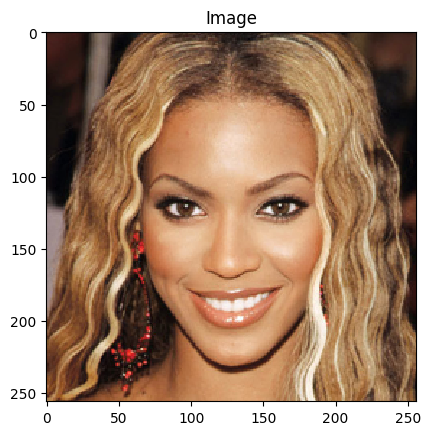

In [5]:
img = Image.open('test/beyonce.jpg')
img = img.convert('RGB')  # if image is RGBA or Grayscale etc
img = np.array(img)
plt.imshow(img)
plt.title('Image')

Text(0.5, 1.0, 'Reconstructed')

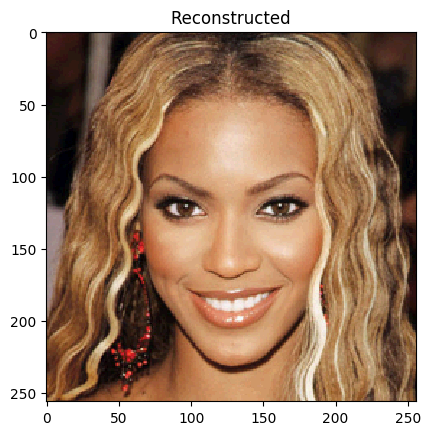

In [6]:
Z = encode(img)
plt.imshow(decode(Z)[0])
plt.title('Reconstructed')

In [0]:
# writer = tf.summary.FileWriter("tmp/",tf.get_default_graph())
# writer.close()
# #pip install tensorboardcolab
# tbc=TensorBoardColab(graph_path='tmp/')

## Moving in the latent space

### Mixing Morphing 

Here we mix two faces by going on a straight line in the Z-Space from one face to the next 

In [0]:
def encode_image(filename):
  img = Image.open(filename)
  img = img.convert('RGB')  # if image is RGBA or Grayscale etc
  img = np.array(img)
  return encode(img)

Z1 = encode_image('test/beyonce.jpg')
Z2 = encode_image('test/leo.png')

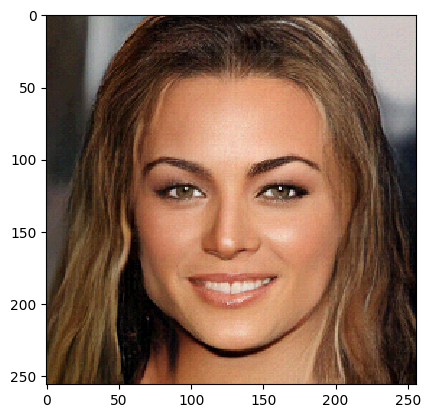

In [9]:
Z_mix = 0.5*(Z1+Z2)
img = decode(Z_mix)[0]
plt.imshow(img)

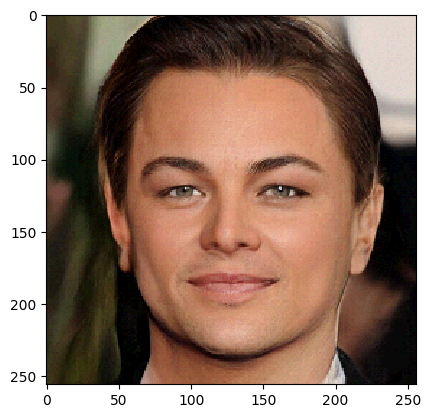

In [10]:
## Task make an image with is 25% Beyonce 75% Leonardo
Z_mix = (Z2*0.75+Z1*0.25)
img = decode(Z_mix)[0]
plt.imshow(img)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


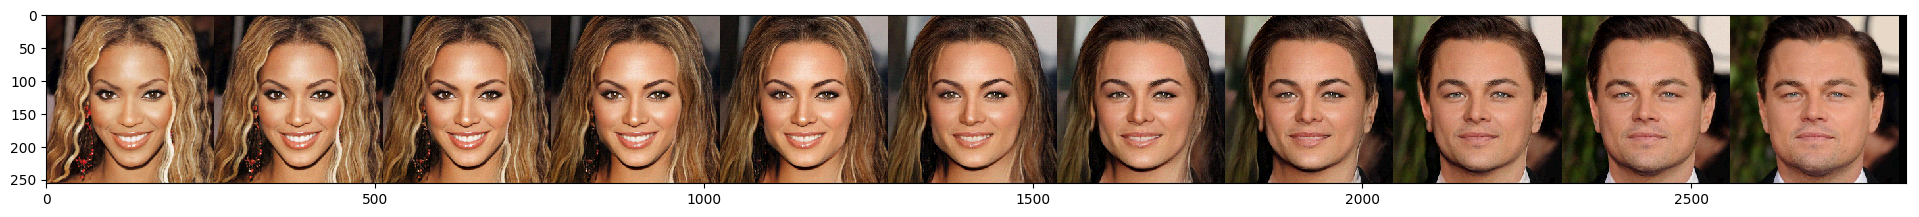

In [11]:
can = np.zeros((1*256,11*257,3),dtype='uint8')
for j in range(11):
    s = 0
    sx = j*256
    m = (j)/10.0
    print(m)
    Z_mix = (Z2*m+Z1*(1.-m))
    img = decode(Z_mix)[0]
    can[s:(s+256) , sx:(sx+256),0:3] = img

plt.figure(figsize=(24,6))
plt.imshow(can)
plt.imsave('beyone_leo.png', can)

### Going along special direction

The Celeb-A dataset is annotated. Using this annotation it is possible to find certain directions in the z-space which correspond to attributes.

In [12]:
z_manipulate = np.load('z_manipulate.npy')
z_manipulate.shape #40 x 196608

_TAGS = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
_TAGS = _TAGS.split() #The names of the 40 attribute
_TAGS.index('Goatee')
_TAGS

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

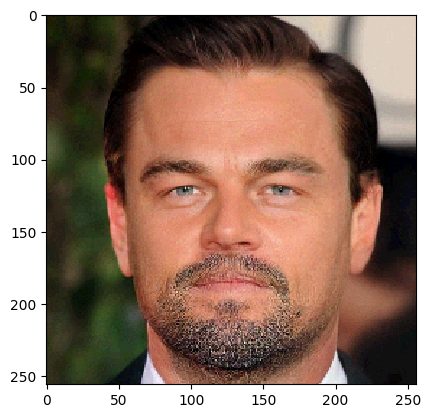

In [13]:
dz = z_manipulate[16]
Z2 = encode_image('test/leo.png')
Z_mix = Z2+dz*0.95
img = decode(Z_mix)[0]
plt.imshow(img)

#### Make Leonardo Smile 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
Exercise: Find the smiling direction and go a step into that direction. If you are using colab use a slide to create an form which you can manipulate.

31

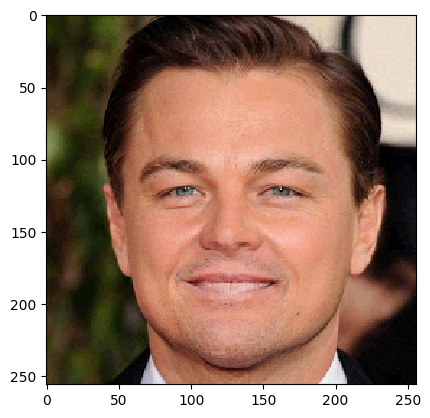

In [14]:
_TAGS.index('Smiling')
Z2 = encode_image('test/leo.png')
dz = z_manipulate[31]
Z_mix = Z2+dz*0.95
img = decode(Z_mix)[0]
plt.imshow(img)
_TAGS.index('Smiling')

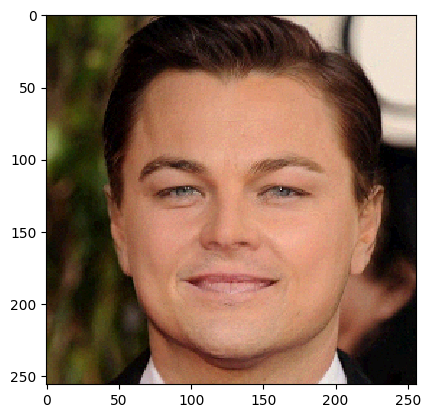

In [35]:
#@title Manipulation { run: "auto" }
smiling = 0.7 #@param {type:"slider", min:-1, max:1, step:0.1}
dz = smiling * z_manipulate[_TAGS.index('Smiling')]

Double_Chin = -0.1 #@param {type:"slider", min:-1, max:1, step:0.1}
dz = dz + Double_Chin * z_manipulate[_TAGS.index('Double_Chin')]

# Goatee = -0.9 #@param {type:"slider", min:-1, max:1, step:0.1}
# dz = dz + Goatee * z_manipulate[_TAGS.index('Goatee')]

young = 0.6 #@param {type:"slider", min:-1, max:1, step:0.1}
dz = dz + young * z_manipulate[_TAGS.index('Young')]


Z_mix = Z2+dz
img = decode(Z_mix)[0]
plt.imshow(img)

#---- Code not maintained below ----

The code below has severe dependencies. It's not maintained and on an as is basis.

# Aligning images

This needs quite some dependencies

In [36]:
#Downloading the pretrained model
# taken from !bash script.sh

!apt update && \
!apt install -y locales cmake libsm6 libxext6 libxrender-dev && \
locale-gen en_US.UTF-8
!export LC_ALL=en_US.UTF-8

# Pip packages for face-aligned (dlib takes a while to install)
!pip install tqdm opencv-python imutils dlib imageio

# Get model weights
# curl https://storage.googleapis.com/glow-demo/large3/graph_optimized.pb > graph_optimized.pb


# Get facial landmarks for aligning input faces
!curl https://storage.googleapis.com/glow-demo/shape_predictor_68_face_landmarks.dat > shape_predictor_68_face_landmarks.dat

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [819 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


In [47]:
# Download some more imapes
!curl https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Donald_Trump_official_portrait.jpg/473px-Donald_Trump_official_portrait.jpg > test/trump.jpg
!curl https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Official_portrait_of_Barack_Obama.jpg/440px-Official_portrait_of_Barack_Obama.jpg > test/obama.jpg
!curl https://s03.s3c.es/imag/_v0/770x420/2/5/1/donald-trump-12diciembre2016-reuters.jpg > test/trump1.jpg
!curl https://raw.githubusercontent.com/openai/glow/master/demo/web/media/beyonce.png > test/beyonce.jpg
!curl https://raw.githubusercontent.com/openai/glow/master/demo/web/media/leo.png > test/leo.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61976  100 61976    0     0   295k      0 --:--:-- --:--:-- --:--:--  295k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36503  100 36503    0     0   451k      0 --:--:-- --:--:-- --:--:--  451k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20412  100 20412    0     0  35747      0 --:--:-- --:--:-- --:--:-- 35685
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  123k  100  123k    0     0   575k      0 --:--:-- --:--:-- --:--:--  575k
  % Total    % Received % Xferd  Average Speed   Tim

In [0]:
#@title Functions provided by openAI { run: "auto" }


# import the necessary packages
from imutils.face_utils import FaceAligner
from PIL import Image
import numpy as np
# import argparse
import imutils
import dlib
import cv2

# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("--shape-predictor", help="path to facial landmark predictor", default='shape_predictor_68_face_landmarks.dat')
# ap.add_argument("--input", help="path to input images", default='input_raw')
# ap.add_argument("--output", help="path to input images", default='input_aligned')
# args = vars(ap.parse_args())

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredFaceWidth=256,
                 desiredLeftEye=(0.371, 0.480))


# Input: numpy array for image with RGB channels
# Output: (numpy array, face_found)
def align_face(img):
    img = img[:, :, ::-1]  # Convert from RGB to BGR format
    img = imutils.resize(img, width=800)

    # detect faces in the grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 2)

    if len(rects) > 0:
        # align the face using facial landmarks
        align_img = fa.align(img, gray, rects[0])[:, :, ::-1]
        align_img = np.array(Image.fromarray(align_img).convert('RGB'))
        return align_img, True
    else:
        # No face found
        return None, False

# Input: img_path
# Output: aligned_img if face_found, else None
def align(img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')  # if image is RGBA or Grayscale etc
    img = np.array(img)
    x, face_found = align_face(img)
    print('Align Face Found ', face_found)
    return x
  

Align Face Found  True


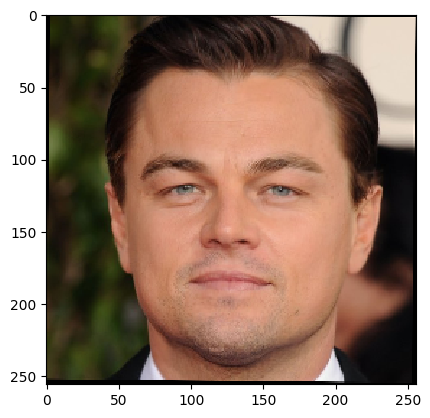

In [19]:
#img = Image.open('test/img.png')
img = align('test/leo.png')
img_a = np.array(img)
plt.imshow(img_a)
plt.imsave('test/leo_a.png', img_a)

# Morphing

Here you can upload your own image

Align Face Found  True
Align Face Found  True


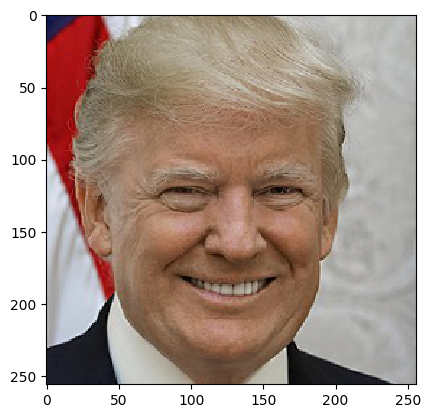

In [25]:
n1 = 'test/obama.jpg'
n2 = 'test/trump.jpg'
#n1 = '/ralf_1.jpg'

img1 = align(n1)
plt.imshow(img1)
img2 = align(n2)
plt.imshow(img2)

z1 = encode(img1)
z2 = encode(img2)
dz = z2 - z1

### Creating a movie

#### Create the images

In [26]:
## Creating the images
import tensorflow as tf
tf.gfile.MkDir('tmp')
names = []
for i in range(100):
  z_inter = z1 + i/100.0 * dz 
  img = decode(z_inter)[0]
  name = 'tmp/ho{:03d}.png'.format(i)
  names.append(name)
  if (i % 10 == 0):
      print('{:03d} {}'.format(i,name))
  plt.imsave(name,np.asarray(img, dtype='uint8'))

000 tmp/ho000.png
010 tmp/ho010.png
020 tmp/ho020.png
030 tmp/ho030.png
040 tmp/ho040.png
050 tmp/ho050.png
060 tmp/ho060.png
070 tmp/ho070.png
080 tmp/ho080.png
090 tmp/ho090.png


#### Append the images 

In [27]:
from imageio import  mimwrite, get_writer
writer = get_writer('zoom.mp4', fps=48, quality=6)
for img in names:
  writer.append_data(plt.imread(img))
for img in reversed(names): 
  writer.append_data(plt.imread(img))
writer.close()

#### Embed the image

In [28]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('zoom.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)